## Task 1: Consumer-Level Flexibility Models

#### Imports

In [1]:
import json
from pathlib import Path
from dataclasses import dataclass, field
from typing import Dict, List, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gurobipy as gp
from gurobipy import GRB

#### Data

In [2]:
DATA_DIR = Path("data/question_1c")

#### Helpers

In [3]:
def load_inputs(data_dir=DATA_DIR):
    with open(data_dir / "appliance_params.json") as f:
        appliance_params = json.load(f)
    with open(data_dir / "bus_params.json") as f:
        bus_params = json.load(f)[0]
    with open(data_dir / "consumer_params.json") as f:
        consumer_params = json.load(f)[0]
    with open(data_dir / "DER_production.json") as f:
        der_prod = json.load(f)[0]
    with open(data_dir / "usage_preferences.json") as f:  # Fixed filename
        usage_pref = json.load(f)[0]
    return appliance_params, bus_params, consumer_params, der_prod, usage_pref

def prepare_base_inputs(appliance_params, bus_params, der_prod, usage_pref):
    T = len(bus_params["energy_price_DKK_per_kWh"])
    price = np.array(bus_params["energy_price_DKK_per_kWh"])
    imp_tariff = np.full(T, bus_params["import_tariff_DKK/kWh"])
    exp_tariff = np.full(T, bus_params["export_tariff_DKK/kWh"])

    # PV parameters
    pv_power = next(d["max_power_kW"] for d in appliance_params["DER"] if d["DER_type"] == "PV")
    pv_profile = np.array(der_prod["hourly_profile_ratio"])
    P_pv = pv_power * pv_profile
    
    # Load parameters
    l_max_hour = next(l["max_load_kWh_per_hour"] for l in appliance_params["load"])
    
    # Calculate L_ref by multiplying the hourly ratio by the max hourly load
    load_prefs = usage_pref["load_preferences"][0]
    hourly_ratios = np.array(load_prefs["hourly_profile_ratio"])
    L_ref = hourly_ratios * l_max_hour
    
    # Battery storage parameters for Task 1c
    battery_params = {}
    if appliance_params["storage"] is not None:
        storage = appliance_params["storage"][0]  # Assume first storage device
        battery_params = {
            "capacity_kWh": storage["storage_capacity_kWh"],
            "max_charge_power_kW": storage["storage_capacity_kWh"] * storage["max_charging_power_ratio"],
            "max_discharge_power_kW": storage["storage_capacity_kWh"] * storage["max_discharging_power_ratio"],
            "charge_efficiency": storage["charging_efficiency"],
            "discharge_efficiency": storage["discharging_efficiency"]
        }
        
        # Battery preferences (initial and final SOC)
        storage_prefs = usage_pref["storage_preferences"][0]
        battery_params.update({
            "initial_soc_ratio": storage_prefs["initial_soc_ratio"],
            "final_soc_ratio": storage_prefs["final_soc_ratio"]
        })
    
    return dict(T=T, price=price, imp_tariff=imp_tariff, exp_tariff=exp_tariff,
                P_pv=P_pv, l_max_hour=l_max_hour, L_ref=L_ref, 
                battery_params=battery_params)

def make_scenarios(base):
    scenarios = {}
    # Base
    scenarios["Base"] = dict(price=base["price"], imp=base["imp_tariff"], exp=base["exp_tariff"])
    # Constant price
    scenarios["Const price"] = dict(price=np.full(base["T"], base["price"].mean()),
                                    imp=base["imp_tariff"], exp=base["exp_tariff"])
    # Net metering
    scenarios["Net metering"] = dict(price=base["price"], imp=np.zeros(base["T"]), exp=np.zeros(base["T"]))
    # No profitable export
    scenarios["No export"] = dict(price=base["price"], imp=base["imp_tariff"],
                                  exp=base["price"]+0.01)
    # Evening spike
    spike = base["price"].copy()
    spike[18:22] *= 2.0
    scenarios["Spike"] = dict(price=spike, imp=base["imp_tariff"], exp=base["exp_tariff"])
    return scenarios

def results_to_dataframe(results, T):
    """Convert results.variables into a tidy DataFrame."""
    df = pd.DataFrame(index=range(T))
    for var, value in results.variables.items():
        # var looks like "l[3]" or "e[10]"
        name, idx = var.split("[")
        t = int(idx.strip("]"))
        df.loc[t, name] = value
    return df.fillna(0.0)

def plot_hourly_flows_with_prices(df, scenario_name, duals=None,
                                  price=None, alpha=None, beta=None, L_ref=None, # NEW: Add L_ref
                                  ylim=(0,6.5),
                                  show_battery=True):
    rename = {
        "l": "Load",
        "p": "PV to bus",
        "e": "Grid imports",
        "s": "PV exported",
        "c": "PV curtailed",
        "d+": "Upward deviation",
        "d-": "Downward deviation",
        "b_ch": "Battery charge",
        "b_dis": "Battery discharge",
        "soc": "Battery SOC"
    }
    df_named = df.rename(columns=rename)

    # Compute total PV generation
    df_named["PV generation"] = (
        df_named.get("PV to bus", 0)
        + df_named.get("PV exported", 0)
        + df_named.get("PV curtailed", 0)
    )

    hours = df_named.index
    width = 0.25
    bar_alpha = 0.85

    plt.rcParams.update({
        "font.size": 14,
        "axes.titlesize": 16,
        "axes.labelsize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 12,
    })

    fig, ax1 = plt.subplots(figsize=(14,6))

    # --- Group 1: PV generation (stacked) ---
    ax1.bar(hours - width, df_named["PV to bus"], width,
            label="PV to bus", color="gold", alpha=bar_alpha)
    ax1.bar(hours - width, df_named["PV exported"], width,
            bottom=df_named["PV to bus"], label="PV exported",
            color="forestgreen", alpha=bar_alpha)
    ax1.bar(hours - width, df_named["PV curtailed"], width,
            bottom=df_named["PV to bus"]+df_named["PV exported"],
            label="PV curtailed", color="lightgray", alpha=bar_alpha)

    # --- PV frame (outline for total generation) ---
    ax1.bar(hours - width, df_named["PV generation"], width,
            fill=False, edgecolor="black", linewidth=0.5,
            label="Total PV generation")

    # --- Group 2: Load with deviations and battery charge stacked on top ---
    base_load = df_named["Load"]
    ax1.bar(hours, base_load, width,
            label="Load", color="royalblue", alpha=bar_alpha)
    
    # Stack upward deviation on top of load
    ax1.bar(hours, df_named.get("Upward deviation", 0), width,
            bottom=base_load, label="Upward deviation", color="cyan", alpha=bar_alpha)
    
    # Stack downward deviation on top of load + upward deviation
    ax1.bar(hours, df_named.get("Downward deviation", 0), width,
            bottom=base_load + df_named.get("Upward deviation", 0), 
            label="Downward deviation", color="magenta", alpha=bar_alpha)
    
    # Stack battery charge on top of everything else in the load bar
    total_deviations = df_named.get("Upward deviation", 0) + df_named.get("Downward deviation", 0)
    ax1.bar(hours, df_named.get("Battery charge", 0), width,
            bottom=base_load + total_deviations,
            label="Battery charge", color="deepskyblue", alpha=bar_alpha)

    # --- Group 3: Imports with battery discharge stacked on top ---
    base_imports = df_named["Grid imports"]
    ax1.bar(hours + width, base_imports, width,
            label="Grid imports", color="firebrick", alpha=bar_alpha)
    
    # Stack battery discharge on top of imports
    ax1.bar(hours + width, df_named.get("Battery discharge", 0), width,
            bottom=base_imports, label="Battery discharge", color="orange", alpha=bar_alpha)
    
    # --- Plot reference load as a line ---
    if L_ref is not None:
        ax1.plot(hours, L_ref, color='darkorange', linestyle='-', drawstyle='steps-mid',
         linewidth=2.5, label='Reference Load')

    # --- Battery SOC line (only if showing battery) ---
    if show_battery and "Battery SOC" in df_named.columns:
        ax1.plot(hours, df_named["Battery SOC"], color="black", linestyle="--", 
                 linewidth=2, label="Battery SOC (kWh)")

    # --- Axis formatting ---
    ax1.set_title(f"Energy flows and prices – {scenario_name}")
    ax1.set_xlabel("Hour of day")
    ax1.set_ylabel("Energy (kWh)")
    ax1.set_ylim(ylim)
    ax1.set_xlim(-0.5, len(hours)-0.5)
    ax1.set_xticks(range(len(hours)))
    ax1.grid(True, which="both", axis="y", linestyle="--", alpha=0.6)

    # --- Second axis: prices ---
    if duals is not None:
        ax2 = ax1.twinx()
        p_int = -pd.Series(duals, index=hours)   # flip sign for internal price
        ax2.plot(hours, p_int, marker="x", linestyle="--",
                 color="purple", linewidth=2, label="Internal price (−λ)")

        if price is not None:
            ax2.plot(hours, price, marker="o", linestyle=":",
                     color="dimgray", linewidth=2, label="Market price π")
        """
        if alpha is not None:
            ax2.plot(hours, alpha, linestyle="--",
                     color="red", linewidth=2, label="Import cost α")
        if beta is not None:
            ax2.plot(hours, beta, linestyle="-.",
                     color="green", linewidth=2, label="Export value β")
        """

        ax2.set_ylabel("Price (DKK/kWh)")
        ax2.tick_params(axis='y', labelcolor="black")

        # Merge legends
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1+lines2, labels1+labels2,
                   loc="upper center", bbox_to_anchor=(0.5, -0.18),
                   ncol=5, frameon=False)
    else:
        ax1.legend(loc="upper center", bbox_to_anchor=(0.5, -0.18),
                   ncol=5, frameon=False)

    plt.tight_layout()
    plt.show()

### Linear Program Scaffold

In [4]:
import gurobipy as gp
from gurobipy import GRB


class InputData:
    def __init__(self, VARIABLES, objective_coeff, constraints_coeff, constraints_rhs, constraints_sense):
        self.VARIABLES = VARIABLES
        self.objective_coeff = objective_coeff
        self.constraints_coeff = constraints_coeff
        self.constraints_rhs = constraints_rhs
        self.constraints_sense = constraints_sense

class LP_OptimizationProblem:

    def __init__(self, input_data: InputData): 
        self.data = input_data 
        self.results = type("Expando", (), {})()  # simple dummy expando
        self._build_model() 
    
    def _build_variables(self):
        self.variables = {v: self.model.addVar(lb=0, name=v) for v in self.data.VARIABLES}
    
    def _build_constraints(self):
        self.constraints = []
        for i in range(len(self.data.constraints_rhs)):
            lhs = gp.quicksum(self.data.constraints_coeff[v][i] * self.variables[v] for v in self.data.VARIABLES)
            constr = self.model.addLConstr(lhs,
                                           self.data.constraints_sense[i],
                                           self.data.constraints_rhs[i],
                                           name=f"constr[{i}]")
            self.constraints.append(constr)

    def _build_objective_function(self):
        objective = gp.quicksum(self.data.objective_coeff[v] * self.variables[v] for v in self.data.VARIABLES)
        self.model.setObjective(objective, GRB.MINIMIZE)

    def _build_model(self):
        self.model = gp.Model(name='Consumer Flexibility')
        self._build_variables()
        self._build_objective_function()
        self._build_constraints()
        self.model.update()
    
    def _save_results(self):
        self.results.objective_value = self.model.ObjVal
        self.results.variables = {v: self.variables[v].X for v in self.data.VARIABLES}
        self.results.duals = {f"constr[{i}]": self.constraints[i].Pi for i in range(len(self.constraints))}

    def run(self):
        self.model.optimize()
        if self.model.status == GRB.OPTIMAL:
            self._save_results()
        else:
            print(f"optimization of {self.model.ModelName} was not successful")
    
    def display_results(self):
        print("\n-------------------   RESULTS  -------------------")
        print("Optimal objective value:", self.results.objective_value)
        print("Optimal variable values:", self.results.variables)
        print("Optimal dual values:", self.results.duals)

### LP Input Function 1a)


In [5]:
def build_input_data(base, scenario):
    T = base["T"]
    price = scenario["price"]   # hourly prices
    imp   = scenario["imp"]     # import tariffs
    exp   = scenario["exp"]     # export tariffs
    P_pv  = base["P_pv"]        # PV availability
    L_min = base["L_min"]       # minimum daily consumption
    l_max_hour = base["l_max_hour"]  # max load per hour

    # Variables: l_t, p_t, e_t, s_t, c_t for each hour
    VARIABLES = []
    for t in range(T):
        VARIABLES += [f"l[{t}]", f"p[{t}]", f"e[{t}]", f"s[{t}]", f"c[{t}]"]

    # Objective coefficients
    objective_coeff = {v: 0 for v in VARIABLES}
    for t in range(T):
        # imports cost π+τ_imp
        objective_coeff[f"e[{t}]"] = price[t] + imp[t]
        # exports revenue π−τ_exp (negative cost)
        objective_coeff[f"s[{t}]"] = -(price[t] - exp[t])
        # l, p, c have zero direct cost

    # Constraint coefficients
    constraints_coeff = {v: [] for v in VARIABLES}
    constraints_rhs = []
    constraints_sense = []

    # (1) Daily minimum consumption: sum l_t >= L_min
    for v in VARIABLES:
        constraints_coeff[v].append(1.0 if v.startswith("l[") else 0.0)
    constraints_rhs.append(L_min)
    constraints_sense.append(GRB.GREATER_EQUAL)

    # (2) Hourly load balance: l_t = p_t + e_t
    for t in range(T):
        for v in VARIABLES:
            if v == f"l[{t}]": coeff = 1.0
            elif v == f"p[{t}]": coeff = -1.0
            elif v == f"e[{t}]": coeff = -1.0
            else: coeff = 0.0
            constraints_coeff[v].append(coeff)
        constraints_rhs.append(0.0)
        constraints_sense.append(GRB.EQUAL)

    # (3) PV split: p_t + s_t + c_t = P^{PV}_t
    for t in range(T):
        for v in VARIABLES:
            if v == f"p[{t}]": coeff = 1.0
            elif v == f"s[{t}]": coeff = 1.0
            elif v == f"c[{t}]": coeff = 1.0
            else: coeff = 0.0
            constraints_coeff[v].append(coeff)
        constraints_rhs.append(P_pv[t])
        constraints_sense.append(GRB.EQUAL)

    # (4) Hourly max load: l_t <= l_max_hour
    for t in range(T):
        for v in VARIABLES:
            # The coefficient is 1.0 only for the l[t] variable in this specific hourly constraint
            if v == f"l[{t}]":
                coeff = 1.0
            else:
                coeff = 0.0
            constraints_coeff[v].append(coeff)
        constraints_rhs.append(l_max_hour)
        constraints_sense.append(GRB.LESS_EQUAL)
        
    return InputData(VARIABLES, objective_coeff, constraints_coeff, constraints_rhs, constraints_sense)

### LP Input Function 1b)

In [6]:
def build_input_data_1b(base, scenario):
    T = base["T"]
    price = scenario["price"]
    imp   = scenario["imp"]
    exp   = scenario["exp"]
    P_pv  = base["P_pv"]
    l_max_hour = base["l_max_hour"]
    # Get the reference load profile
    L_ref = base["L_ref"]

    # --- 1. Define New Variables ---
    # Add d+[t] (upward deviation) and d-[t] (downward deviation)
    VARIABLES = []
    for t in range(T):
        VARIABLES += [f"l[{t}]", f"p[{t}]", f"e[{t}]", f"s[{t}]", f"c[{t}]", f"d+[{t}]", f"d-[{t}]"]

    # --- 2. Update Objective Function ---
    objective_coeff = {v: 0 for v in VARIABLES}
    for t in range(T):
        # Energy costs (same as before)
        objective_coeff[f"e[{t}]"] = price[t] + imp[t]
        objective_coeff[f"s[{t}]"] = -(price[t] - exp[t])
        
        # Add discomfort cost (using gamma_t = price_t)
        objective_coeff[f"d+[{t}]"] = price[t] * 1.2 # Slightly higher cost for upward deviation
        objective_coeff[f"d-[{t}]"] = price[t] * 1.3  # Higher cost for downward deviation

    # --- Constraints ---
    constraints_coeff = {v: [] for v in VARIABLES}
    constraints_rhs = []
    constraints_sense = []

    # --- 3. REMOVE Daily Minimum Consumption Constraint ---
    # The L_min constraint block is deleted.

    # (1) Hourly load balance: l_t - p_t - e_t = 0 (Unchanged from 1a)
    for t in range(T):
        for v in VARIABLES:
            if v == f"l[{t}]": coeff = 1.0
            elif v == f"p[{t}]": coeff = -1.0
            elif v == f"e[{t}]": coeff = -1.0
            else: coeff = 0.0
            constraints_coeff[v].append(coeff)
        constraints_rhs.append(0.0)
        constraints_sense.append(GRB.EQUAL)

    # (2) PV split: p_t + s_t + c_t = P^{PV}_t (Unchanged from 1a)
    for t in range(T):
        for v in VARIABLES:
            if v == f"p[{t}]": coeff = 1.0
            elif v == f"s[{t}]": coeff = 1.0
            elif v == f"c[{t}]": coeff = 1.0
            else: coeff = 0.0
            constraints_coeff[v].append(coeff)
        constraints_rhs.append(P_pv[t])
        constraints_sense.append(GRB.EQUAL)

    # (3) Hourly max load: l_t <= l_max_hour (Unchanged from 1a)
    for t in range(T):
        for v in VARIABLES:
            if v == f"l[{t}]": coeff = 1.0
            else: coeff = 0.0
            constraints_coeff[v].append(coeff)
        constraints_rhs.append(l_max_hour)
        constraints_sense.append(GRB.LESS_EQUAL)
        
    # --- 4. ADD Load Deviation Constraint ---
    # l_t - d+_t + d-_t = L_ref_t
    for t in range(T):
        for v in VARIABLES:
            if v == f"l[{t}]": coeff = 1.0
            elif v == f"d+[{t}]": coeff = -1.0
            elif v == f"d-[{t}]": coeff = 1.0
            else: coeff = 0.0
            constraints_coeff[v].append(coeff)
        constraints_rhs.append(L_ref[t])
        constraints_sense.append(GRB.EQUAL)
            
    return InputData(VARIABLES, objective_coeff, constraints_coeff, constraints_rhs, constraints_sense)

### LP Input Function 1c)

In [7]:
def build_input_data_1c(base, scenario):
    T = base["T"]
    price = scenario["price"]
    imp = scenario["imp"]
    exp = scenario["exp"]
    P_pv = base["P_pv"]
    l_max_hour = base["l_max_hour"]
    L_ref = base["L_ref"]
    battery = base["battery_params"]

    # --- Variables ---
    VARIABLES = []
    for t in range(T):
        VARIABLES += [
            f"l[{t}]", f"p[{t}]", f"e[{t}]", f"s[{t}]", f"c[{t}]",
            f"d+[{t}]", f"d-[{t}]",
            f"b_ch[{t}]", f"b_dis[{t}]", f"soc[{t}]"
        ]

    # --- Objective Function ---
    objective_coeff = {v: 0 for v in VARIABLES}
    for t in range(T):
        objective_coeff[f"e[{t}]"] = price[t] + imp[t]
        objective_coeff[f"s[{t}]"] = -(price[t] - exp[t])
        objective_coeff[f"d+[{t}]"] = price[t] * 1.2
        objective_coeff[f"d-[{t}]"] = price[t] * 1.3
        # Battery charge/discharge and SOC have no direct cost

    # --- Constraints ---
    constraints_coeff = {v: [] for v in VARIABLES}
    constraints_rhs = []
    constraints_sense = []

    # (1) Hourly load balance: l_t = p_t + e_t + b_dis_t - b_ch_t
    for t in range(T):
        for v in VARIABLES:
            if v == f"l[{t}]": coeff = 1.0
            elif v == f"p[{t}]": coeff = -1.0
            elif v == f"e[{t}]": coeff = -1.0
            elif v == f"b_dis[{t}]": coeff = -1.0
            elif v == f"b_ch[{t}]": coeff = 1.0
            else: coeff = 0.0
            constraints_coeff[v].append(coeff)
        constraints_rhs.append(0.0)
        constraints_sense.append(GRB.EQUAL)

    # (2) PV split: p_t + s_t + c_t + b_ch_t = P^{PV}_t
    for t in range(T):
        for v in VARIABLES:
            if v == f"p[{t}]": coeff = 1.0
            elif v == f"s[{t}]": coeff = 1.0
            elif v == f"c[{t}]": coeff = 1.0
            elif v == f"b_ch[{t}]": coeff = 1.0
            else: coeff = 0.0
            constraints_coeff[v].append(coeff)
        constraints_rhs.append(P_pv[t])
        constraints_sense.append(GRB.EQUAL)

    # (3) Hourly max load: l_t <= l_max_hour
    for t in range(T):
        for v in VARIABLES:
            if v == f"l[{t}]": coeff = 1.0
            else: coeff = 0.0
            constraints_coeff[v].append(coeff)
        constraints_rhs.append(l_max_hour)
        constraints_sense.append(GRB.LESS_EQUAL)

    # (4) Load deviation: l_t - d+_t + d-_t = L_ref_t
    for t in range(T):
        for v in VARIABLES:
            if v == f"l[{t}]": coeff = 1.0
            elif v == f"d+[{t}]": coeff = -1.0
            elif v == f"d-[{t}]": coeff = 1.0
            else: coeff = 0.0
            constraints_coeff[v].append(coeff)
        constraints_rhs.append(L_ref[t])
        constraints_sense.append(GRB.EQUAL)

    # (5) Battery charge/discharge limits
    max_charge = battery["max_charge_power_kW"]
    max_discharge = battery["max_discharge_power_kW"]
    for t in range(T):
        # b_ch_t <= max_charge
        for v in VARIABLES:
            coeff = 1.0 if v == f"b_ch[{t}]" else 0.0
            constraints_coeff[v].append(coeff)
        constraints_rhs.append(max_charge)
        constraints_sense.append(GRB.LESS_EQUAL)
        # b_dis_t <= max_discharge
        for v in VARIABLES:
            coeff = 1.0 if v == f"b_dis[{t}]" else 0.0
            constraints_coeff[v].append(coeff)
        constraints_rhs.append(max_discharge)
        constraints_sense.append(GRB.LESS_EQUAL)

    # (6) Battery SOC dynamics
    eta_ch = battery["charge_efficiency"]
    eta_dis = battery["discharge_efficiency"]
    for t in range(T):
        for v in VARIABLES:
            if v == f"soc[{t}]": coeff = 1.0
            elif v == f"soc[{t-1}]": coeff = -1.0 if t > 0 else 0.0
            elif v == f"b_ch[{t}]": coeff = -eta_ch
            elif v == f"b_dis[{t}]": coeff = 1.0 / eta_dis
            else: coeff = 0.0
            constraints_coeff[v].append(coeff)
        if t == 0:
            soc0 = battery["initial_soc_ratio"] * battery["capacity_kWh"]
            constraints_rhs.append(soc0)
        else:
            constraints_rhs.append(0.0)
        constraints_sense.append(GRB.EQUAL)

    # (7) SOC bounds
    for t in range(T):
        # soc_t <= capacity
        for v in VARIABLES:
            coeff = 1.0 if v == f"soc[{t}]" else 0.0
            constraints_coeff[v].append(coeff)
        constraints_rhs.append(battery["capacity_kWh"])
        constraints_sense.append(GRB.LESS_EQUAL)
        # soc_t >= 0
        for v in VARIABLES:
            coeff = 1.0 if v == f"soc[{t}]" else 0.0
            constraints_coeff[v].append(coeff)
        constraints_rhs.append(0.0)
        constraints_sense.append(GRB.GREATER_EQUAL)

    # (8) Final SOC constraint
    final_soc = battery["final_soc_ratio"] * battery["capacity_kWh"]
    for v in VARIABLES:
        coeff = 1.0 if v == f"soc[{T-1}]" else 0.0
        constraints_coeff[v].append(coeff)
    constraints_rhs.append(final_soc)
    constraints_sense.append(GRB.EQUAL)

    return InputData(VARIABLES, objective_coeff, constraints_coeff, constraints_rhs, constraints_sense)

In [8]:
# Load inputs and prepare base data
appliance_params, bus_params, consumer_params, der_prod, usage_pref = load_inputs()
base = prepare_base_inputs(appliance_params, bus_params, der_prod, usage_pref)
scenarios = make_scenarios(base)

scenario_name = "Base"
sc = scenarios[scenario_name]

input_data = build_input_data_1c(base, sc)
problem = LP_OptimizationProblem(input_data)
problem.run()

df = results_to_dataframe(problem.results, base["T"])
print(df.head())

Set parameter Username
Set parameter LicenseID to value 2625590
Academic license - for non-commercial use only - expires 2026-02-20
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 217 rows, 240 columns and 504 nonzeros
Model fingerprint: 0x545a2413
Coefficient statistics:
  Matrix range     [9e-01, 1e+00]
  Objective range  [4e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 6e+00]
Presolve removed 144 rows and 73 columns
Presolve time: 0.00s
Presolved: 73 rows, 167 columns, 269 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1224500e+01   3.078667e+01   0.000000e+00      0s
      73    2.9841945e+01   0.000000e+00   0.000000e+00      0s

Solved in 73 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.984194500e+01
     l    p    e    s    c   d+    

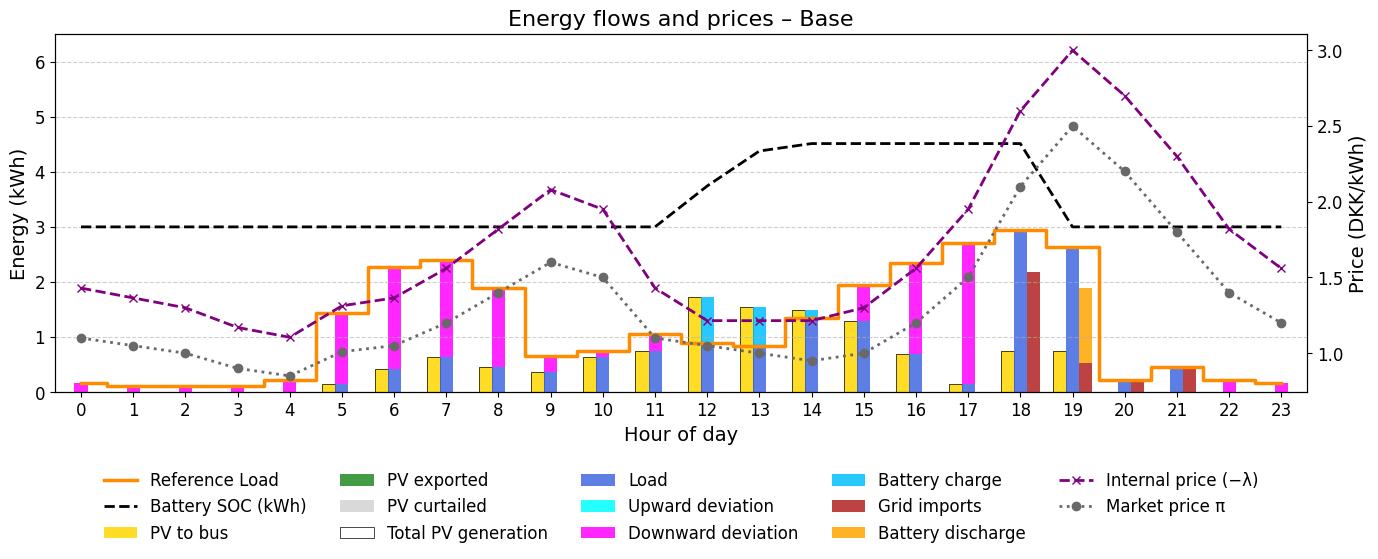

In [9]:
duals_lambda = [problem.results.duals[f"constr[{i}]"] for i in range(base["T"])]

plot_hourly_flows_with_prices(
    df,
    scenario_name,
    duals=duals_lambda,
    price=sc["price"],
    alpha=sc["price"] + sc["imp"],
    beta=sc["price"] - sc["exp"],
    L_ref=base["L_ref"],
    show_battery=True
)

#### Analysis and Visualizations

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 217 rows, 240 columns and 504 nonzeros
Model fingerprint: 0x545a2413
Coefficient statistics:
  Matrix range     [9e-01, 1e+00]
  Objective range  [4e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 6e+00]
Presolve removed 144 rows and 73 columns
Presolve time: 0.00s
Presolved: 73 rows, 167 columns, 269 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1224500e+01   3.078667e+01   0.000000e+00      0s
      73    2.9841945e+01   0.000000e+00   0.000000e+00      0s

Solved in 73 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.984194500e+01


,lambda,rho,nu,delta,alpha,beta,kappa,omega_up,omega_low
h0,-1.430,-1.430,0.0,1.430,0.0,0.0,-2.7,0.0,0.0
h1,-1.365,-1.365,0.0,1.365,0.0,0.0,-2.7,0.0,0.0
h2,-1.300,-1.300,0.0,1.300,0.0,0.0,-2.7,0.0,0.0
h3,-1.170,-1.260,0.0,1.170,0.0,0.0,-2.7,0.0,0.0
h4,-1.105,-1.325,0.0,1.105,0.0,0.0,-2.7,0.0,0.0
h5,-1.313,-1.313,0.0,1.313,0.0,0.0,-2.7,0.0,0.0
h6,-1.365,-1.365,0.0,1.365,0.0,0.0,-2.7,0.0,0.0
h7,-1.560,-1.560,0.0,1.560,0.0,0.0,-2.7,0.0,0.0
h8,-1.820,-1.820,0.0,1.820,0.0,0.0,-2.7,0.0,0.0
h9,-2.080,-2.080,0.0,2.080,0.0,0.0,-2.7,0.0,0.0


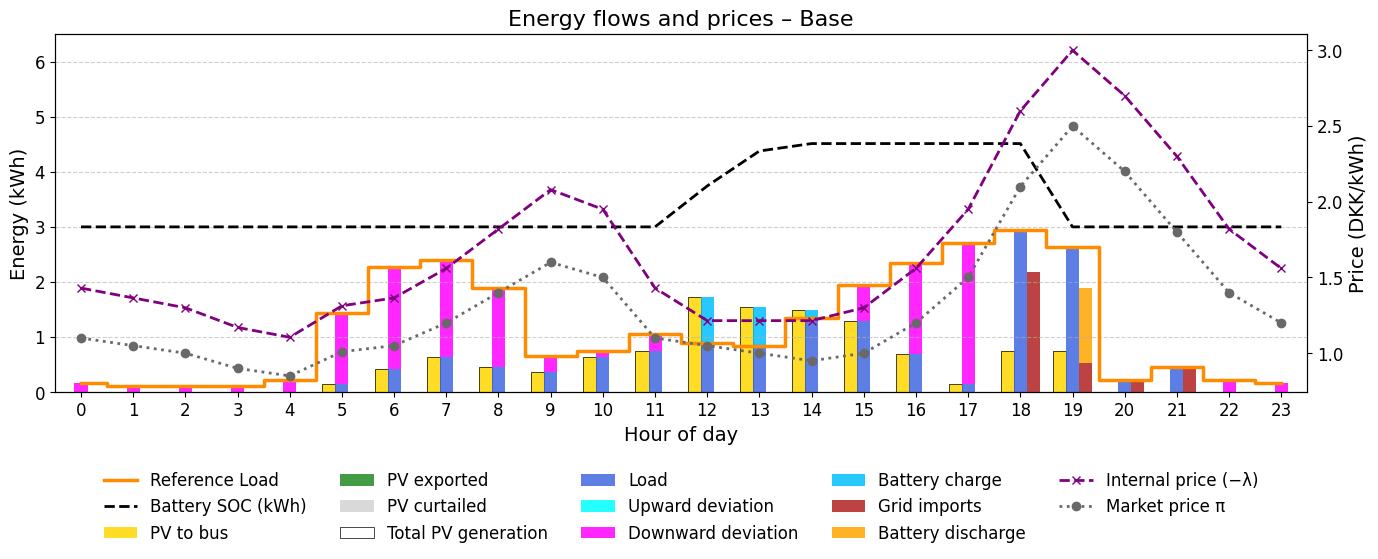

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 217 rows, 240 columns and 504 nonzeros
Model fingerprint: 0xed6cbb04
Coefficient statistics:
  Matrix range     [9e-01, 1e+00]
  Objective range  [9e-01, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 6e+00]
Presolve removed 146 rows and 77 columns
Presolve time: 0.00s
Presolved: 71 rows, 163 columns, 263 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.2381175e+01   3.048667e+01   0.000000e+00      0s
      53    2.7497139e+01   0.000000e+00   0.000000e+00      0s

Solved in 53 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.749713875e+01


,lambda,rho,nu,delta,alpha,beta,kappa,omega_up,omega_low
h0,-1.7149,-1.7149,0.0,1.7149,0.0,0.0,-1.5434,0.0,0.0
h1,-1.7149,-1.7149,0.0,1.7149,0.0,0.0,-1.5434,0.0,0.0
h2,-1.7149,-1.7149,0.0,1.7149,0.0,0.0,-1.5434,0.0,0.0
h3,-1.7149,-1.7149,0.0,1.7149,0.0,0.0,-1.5434,0.0,0.0
h4,-1.7149,-1.7149,0.0,1.7149,0.0,0.0,-1.5434,0.0,0.0
h5,-1.7149,-1.7149,0.0,1.7149,0.0,0.0,-1.5434,0.0,0.0
h6,-1.7149,-1.7149,0.0,1.7149,0.0,0.0,-1.5434,0.0,0.0
h7,-1.7149,-1.7149,0.0,1.7149,0.0,0.0,-1.5434,0.0,0.0
h8,-1.7149,-1.7149,0.0,1.7149,0.0,0.0,-1.5434,0.0,0.0
h9,-1.7149,-1.7149,0.0,1.7149,0.0,0.0,-1.5434,0.0,0.0


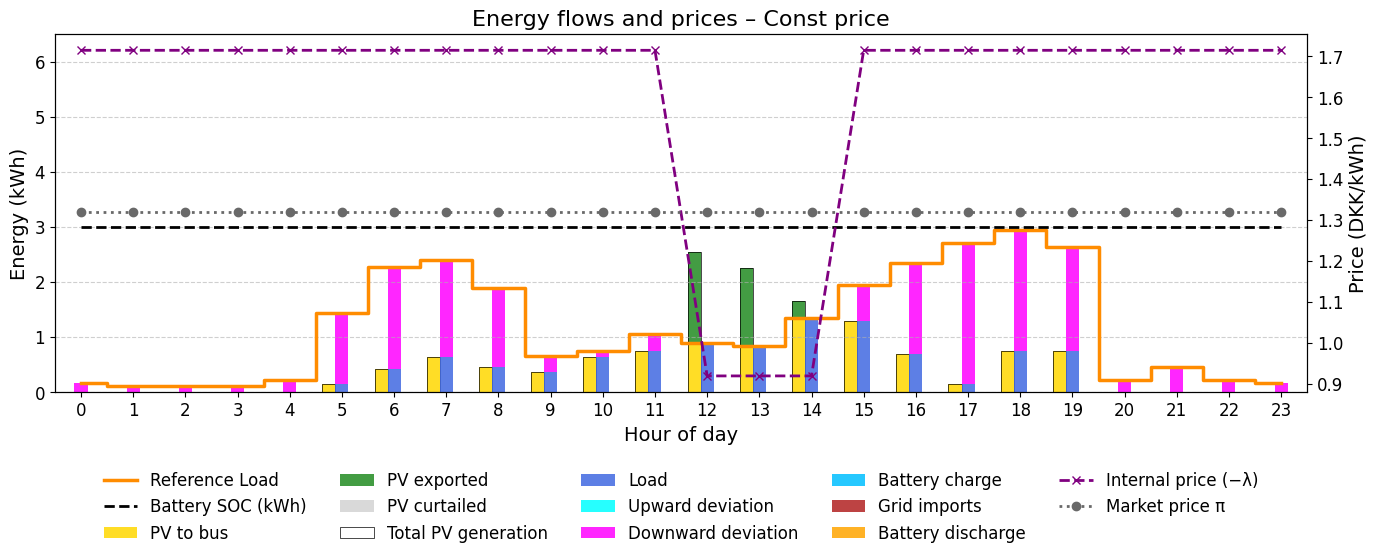

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 217 rows, 240 columns and 504 nonzeros
Model fingerprint: 0xeabbab4f
Coefficient statistics:
  Matrix range     [9e-01, 1e+00]
  Objective range  [8e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 6e+00]
Presolve removed 137 rows and 59 columns
Presolve time: 0.00s
Presolved: 80 rows, 181 columns, 290 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6612500e+01   3.271500e+01   0.000000e+00      0s
      54    2.3146594e+01   0.000000e+00   0.000000e+00      0s

Solved in 54 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.314659444e+01


,lambda,rho,nu,delta,alpha,beta,kappa,omega_up,omega_low
h0,-1.10,-1.10,0.0,1.10,0.0,0.0000,-2.2222,0.0,0.0
h1,-1.05,-1.05,0.0,1.05,0.0,0.0000,-2.2222,0.0,0.0
h2,-1.00,-1.00,0.0,1.00,0.0,0.0000,-2.2222,0.0,0.0
h3,-0.90,-1.10,0.0,0.90,0.0,0.0000,-2.2222,0.0,0.0
h4,-0.85,-1.15,0.0,0.85,0.0,-0.1000,-2.2222,0.0,0.0
h5,-1.01,-1.01,0.0,1.01,0.0,0.0000,-2.2222,0.0,0.0
h6,-1.05,-1.05,0.0,1.05,0.0,0.0000,-2.2222,0.0,0.0
h7,-1.20,-1.20,0.0,1.20,0.0,0.0000,-2.2222,0.0,0.0
h8,-1.40,-1.40,0.0,1.40,0.0,0.0000,-2.2222,0.0,0.0
h9,-1.60,-1.60,0.0,1.60,0.0,0.0000,-2.2222,0.0,0.0


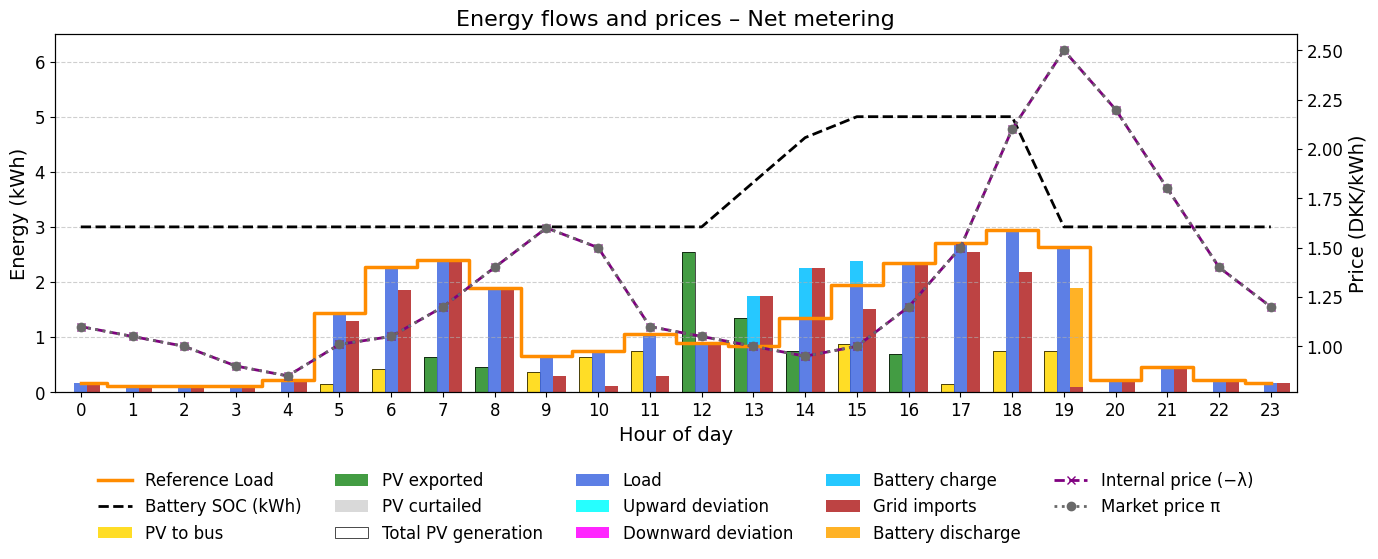

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 217 rows, 240 columns and 504 nonzeros
Model fingerprint: 0xdb6b8f89
Coefficient statistics:
  Matrix range     [9e-01, 1e+00]
  Objective range  [1e-02, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 6e+00]
Presolve removed 144 rows and 88 columns
Presolve time: 0.00s
Presolved: 73 rows, 152 columns, 254 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.078667e+01   0.000000e+00      0s
      66    2.9841945e+01   0.000000e+00   0.000000e+00      0s

Solved in 66 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.984194500e+01


,lambda,rho,nu,delta,alpha,beta,kappa,omega_up,omega_low
h0,-1.430,-1.430,0.0,1.430,0.0,0.0,-2.7,0.0,0.0
h1,-1.365,-1.365,0.0,1.365,0.0,0.0,-2.7,0.0,0.0
h2,-1.300,-1.300,0.0,1.300,0.0,0.0,-2.7,0.0,0.0
h3,-1.170,-1.260,0.0,1.170,0.0,0.0,-2.7,0.0,0.0
h4,-1.105,-1.325,0.0,1.105,0.0,0.0,-2.7,0.0,0.0
h5,-1.313,-1.313,0.0,1.313,0.0,0.0,-2.7,0.0,0.0
h6,-1.365,-1.365,0.0,1.365,0.0,0.0,-2.7,0.0,0.0
h7,-1.560,-1.560,0.0,1.560,0.0,0.0,-2.7,0.0,0.0
h8,-1.820,-1.820,0.0,1.820,0.0,0.0,-2.7,0.0,0.0
h9,-2.080,-2.080,0.0,2.080,0.0,0.0,-2.7,0.0,0.0


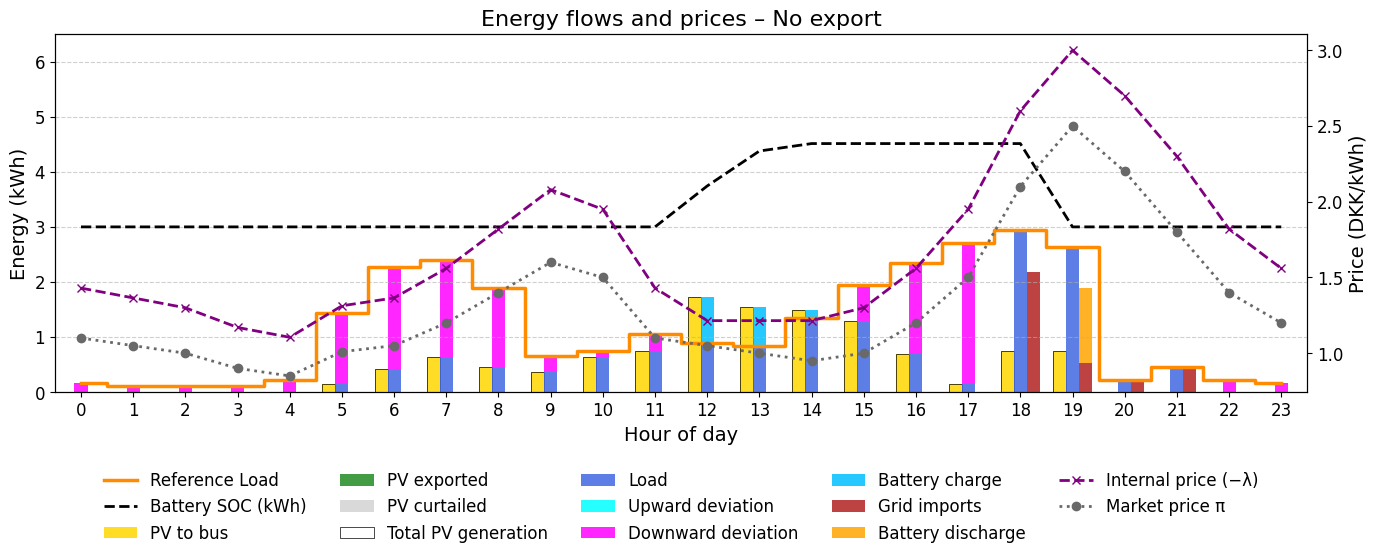

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 217 rows, 240 columns and 504 nonzeros
Model fingerprint: 0x16d55eaa
Coefficient statistics:
  Matrix range     [9e-01, 1e+00]
  Objective range  [4e-01, 6e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 6e+00]
Presolve removed 144 rows and 73 columns
Presolve time: 0.00s
Presolved: 73 rows, 167 columns, 269 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.4674500e+01   3.078667e+01   0.000000e+00      0s
      72    3.4599445e+01   0.000000e+00   0.000000e+00      0s

Solved in 72 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.459944500e+01


,lambda,rho,nu,delta,alpha,beta,kappa,omega_up,omega_low
h0,-1.430,-1.430,0.0,1.430,0.0,0.00,-3.0333,0.0,0.0000
h1,-1.365,-1.365,0.0,1.365,0.0,0.00,-3.0333,0.0,0.0000
h2,-1.300,-1.430,0.0,1.300,0.0,-0.13,-3.0333,0.0,0.0000
h3,-1.170,-1.560,0.0,1.170,0.0,0.00,-3.0333,0.0,0.0000
h4,-1.105,-1.625,0.0,1.105,0.0,0.00,-3.0333,0.0,0.0000
h5,-1.365,-1.365,0.0,1.313,0.0,0.00,-3.0333,0.0,0.0000
h6,-1.365,-1.365,0.0,1.365,0.0,0.00,-3.0333,0.0,0.0000
h7,-1.560,-1.560,0.0,1.560,0.0,0.00,-3.0333,0.0,0.0000
h8,-1.820,-1.820,0.0,1.820,0.0,0.00,-3.0333,0.0,-1.1967
h9,-2.080,-2.080,0.0,2.080,0.0,0.00,-3.0333,0.0,0.0000


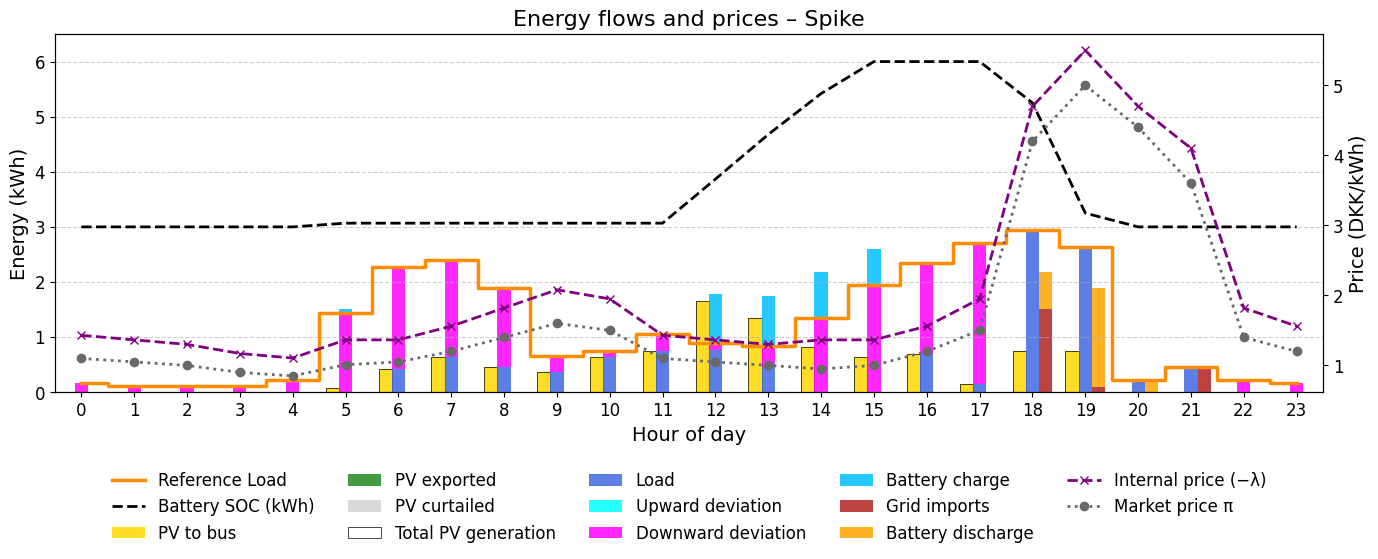

,Objective,Total import,Total export,Total curtailed,Total load,Total upward dev,Total downward dev,Total battery charge,Total battery discharge,Final SOC
Base,29.841945,3.394200,0.00,0.0,14.865000,0.0,13.080000,1.680000,1.3608,3.0
Const price,27.497139,0.000000,3.36,0.0,10.110000,0.0,17.835000,0.000000,0.0000,3.0
Net metering,23.146594,23.539444,6.42,0.0,27.945000,0.0,0.000000,2.222222,1.8000,3.0
No export,29.841945,3.394200,0.00,0.0,14.865000,0.0,13.080000,1.680000,1.3608,3.0
Spike,34.599445,2.055000,0.00,0.0,11.558333,0.0,16.386667,3.333333,2.7000,3.0


In [19]:
scenario_names = ["Base", "Const price", "Net metering", "No export", "Spike"]

dfs = []
duals_list = []
price_list = []
alpha_list = []
beta_list = []
l_ref_list = []
results_summary = {}

for scenario_name in scenario_names:
    sc = scenarios[scenario_name]
    input_data = build_input_data_1c(base, sc)
    problem = LP_OptimizationProblem(input_data)
    problem.run()
    df = results_to_dataframe(problem.results, base["T"])
    dfs.append(df)
    duals_lambda = [problem.results.duals[f"constr[{i}]"] for i in range(base["T"])]
    duals_list.append(duals_lambda)
    price_list.append(sc["price"])
    alpha_list.append(sc["price"] + sc["imp"])
    beta_list.append(sc["price"] - sc["exp"])
    l_ref_list.append(base["L_ref"])
    results_summary[scenario_name] = {
        "Objective": problem.results.objective_value,
        "Total import": df["e"].sum(),
        "Total export": df["s"].sum(),
        "Total curtailed": df["c"].sum(),
        "Total load": df["l"].sum(),
        "Total upward dev": df["d+"].sum(),
        "Total downward dev": df["d-"].sum(),
        "Total battery charge": df["b_ch"].sum(),
        "Total battery discharge": df["b_dis"].sum(),
        "Final SOC": df["soc"].iloc[-1]
    }


    duals_display = collect_duals_by_index(problem, base["T"])
    df_duals_display = duals_to_dataframe(duals_display)
    display(df_duals_display.T)
    plot_hourly_flows_with_prices(
        df,
        scenario_name,
        duals=duals_lambda,
        price=sc["price"],
        alpha=sc["price"] + sc["imp"],
        beta=sc["price"] - sc["exp"],
        L_ref=base["L_ref"],
        show_battery=True
    )

df_results = pd.DataFrame(results_summary).T
df_results

### Reporting

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_scenarios_subplots_battery(
    scenario_results, titles, price_list, alpha_list, beta_list,
    duals_list, L_ref_list=None, ylim=(0,6.5)
):
    """
    Create vertically stacked subplots for all scenarios, including battery behavior.
    """

    n_scen = len(scenario_results)
    fig, axes = plt.subplots(nrows=n_scen, ncols=1,
                             figsize=(14, 4*n_scen), sharex=True)

    if n_scen == 1:
        axes = [axes]

    for ax1, df, title, price, alpha, beta, duals, L_ref in zip(
        axes, scenario_results, titles, price_list, alpha_list, beta_list, duals_list,
        L_ref_list or [None]*n_scen):

        rename = {
            "l": "Load",
            "p": "PV to bus",
            "e": "Grid imports",
            "s": "PV exported",
            "c": "PV curtailed",
            "d+": "Upward deviation",
            "d-": "Downward deviation",
            "b_ch": "Battery charge",
            "b_dis": "Battery discharge",
            "soc": "Battery SOC"
        }
        df_named = df.rename(columns=rename)

        # --- Derived values ---
        df_named["PV generation"] = (
            df_named.get("PV to bus", 0)
            + df_named.get("PV exported", 0)
            + df_named.get("PV curtailed", 0)
        )

        hours = df_named.index
        width = 0.25
        bar_alpha = 0.85

        # --- PV generation group (left bars) ---
        ax1.bar(hours - width, df_named.get("PV to bus", 0), width,
                label="PV to bus", color="gold", alpha=bar_alpha)
        ax1.bar(hours - width, df_named.get("PV exported", 0), width,
                bottom=df_named.get("PV to bus", 0),
                label="PV exported", color="forestgreen", alpha=bar_alpha)
        ax1.bar(hours - width, df_named.get("PV curtailed", 0), width,
                bottom=df_named.get("PV to bus", 0) + df_named.get("PV exported", 0),
                label="PV curtailed", color="lightgray", alpha=bar_alpha)
        ax1.bar(hours - width, df_named["PV generation"], width,
                fill=False, edgecolor="black", linewidth=0.5,
                label="Total PV generation")

        # --- Load + deviations + battery charge (center bars) ---
        base_load = df_named.get("Load", 0)
        ax1.bar(hours, base_load, width,
                label="Load", color="royalblue", alpha=bar_alpha)

        ax1.bar(hours, df_named.get("Upward deviation", 0), width,
                bottom=base_load, label="Upward deviation", color="mediumvioletred", alpha=bar_alpha)
        ax1.bar(hours, df_named.get("Downward deviation", 0), width,
                bottom=base_load + df_named.get("Upward deviation", 0),
                label="Downward deviation", color="magenta", alpha=bar_alpha)
        total_dev = df_named.get("Upward deviation", 0) + df_named.get("Downward deviation", 0)
        ax1.bar(hours, df_named.get("Battery charge", 0), width,
                bottom=base_load + total_dev,
                label="Battery charge", color="deepskyblue", alpha=bar_alpha)

        # --- Imports + battery discharge (right bars) ---
        base_imports = df_named.get("Grid imports", 0)
        ax1.bar(hours + width, base_imports, width,
                label="Grid imports", color="firebrick", alpha=bar_alpha)
        ax1.bar(hours + width, df_named.get("Battery discharge", 0), width,
                bottom=base_imports,
                label="Battery discharge", color="orange", alpha=bar_alpha)

        # --- Optional: Reference load line ---
        if L_ref is not None:
            ax1.plot(hours, L_ref, color='darkorange', linestyle='-', drawstyle='steps-mid',
                     linewidth=2.5, label='Reference Load')

        # --- Optional: Battery SOC line ---
        if "Battery SOC" in df_named.columns:
            ax1.plot(hours, df_named["Battery SOC"], color="black", linestyle="--",
                     linewidth=2, label="Battery SOC (kWh)")

        # --- Formatting ---
        ax1.set_title(title)
        ax1.set_ylabel("Energy (kWh)")
        ax1.set_ylim(ylim)
        ax1.set_xlim(-0.5, len(hours)-0.5)
        ax1.set_xticks(range(len(hours)))
        ax1.set_xticklabels(range(len(hours)))
        ax1.tick_params(labelbottom=True)
        if ax1 == axes[-1]:
            ax1.set_xlabel("Hour of day")

        ax1.grid(True, which="both", axis="y", linestyle="--", alpha=0.6)

        # --- Prices (right axis) ---
        ax2 = ax1.twinx()
        p_int = -pd.Series(duals, index=hours)
        ax2.plot(hours, p_int, marker="x", linestyle="--",
                 color="purple", linewidth=2, label="Internal price (λ)")
        ax2.plot(hours, price, marker="o", linestyle=":",
                 color="dimgray", linewidth=2, label="Market price π")
        ax2.plot(hours, alpha, linestyle="--",
                 color="red", linewidth=2, label="Import cost α")
        ax2.plot(hours, beta, linestyle="-.",
                 color="green", linewidth=2, label="Export value β")
        ax2.set_ylabel("Price (DKK/kWh)")
        ax2.tick_params(axis='y', labelcolor="black")
        ax2.set_ylim(0, 6)

        ax1.right_ax = ax2

    # --- Shared legend ---
    handles1, labels1 = axes[0].get_legend_handles_labels()
    handles2, labels2 = axes[0].right_ax.get_legend_handles_labels()
    fig.legend(handles1+handles2, labels1+labels2,
               loc="lower center", bbox_to_anchor=(0.5, -0.0125),
               ncol=5, frameon=False)
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.show()

def clean_net_metering_solution(df):
    """
    Post-process LP results for Net Metering scenario:
    If import and export occur simultaneously, allocate exports to self-consumption first,
    then use imports only for remaining load.
    """
    df_clean = df.copy()

    for t in df_clean.index:
        e = df_clean.loc[t, "e"]
        s = df_clean.loc[t, "s"]
        p = df_clean.loc[t, "p"]

        if e > 1e-6 and s > 1e-6:
            delta = min(e, s)
            df_clean.loc[t, "e"] = e - delta
            df_clean.loc[t, "s"] = s - delta
            df_clean.loc[t, "p"] = p + delta
            # DO NOT change l, b_ch, b_dis, soc

    return df_clean

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 217 rows, 240 columns and 504 nonzeros
Model fingerprint: 0x545a2413
Coefficient statistics:
  Matrix range     [9e-01, 1e+00]
  Objective range  [4e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 6e+00]
Presolve removed 144 rows and 73 columns
Presolve time: 0.00s
Presolved: 73 rows, 167 columns, 269 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1224500e+01   3.078667e+01   0.000000e+00      0s
      73    2.9841945e+01   0.000000e+00   0.000000e+00      0s

Solved in 73 iterations and 0.01 seconds (0.00 work units)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 217 rows, 240 columns and 504 nonzeros
Model fingerprint: 0x545a2413
Coefficie

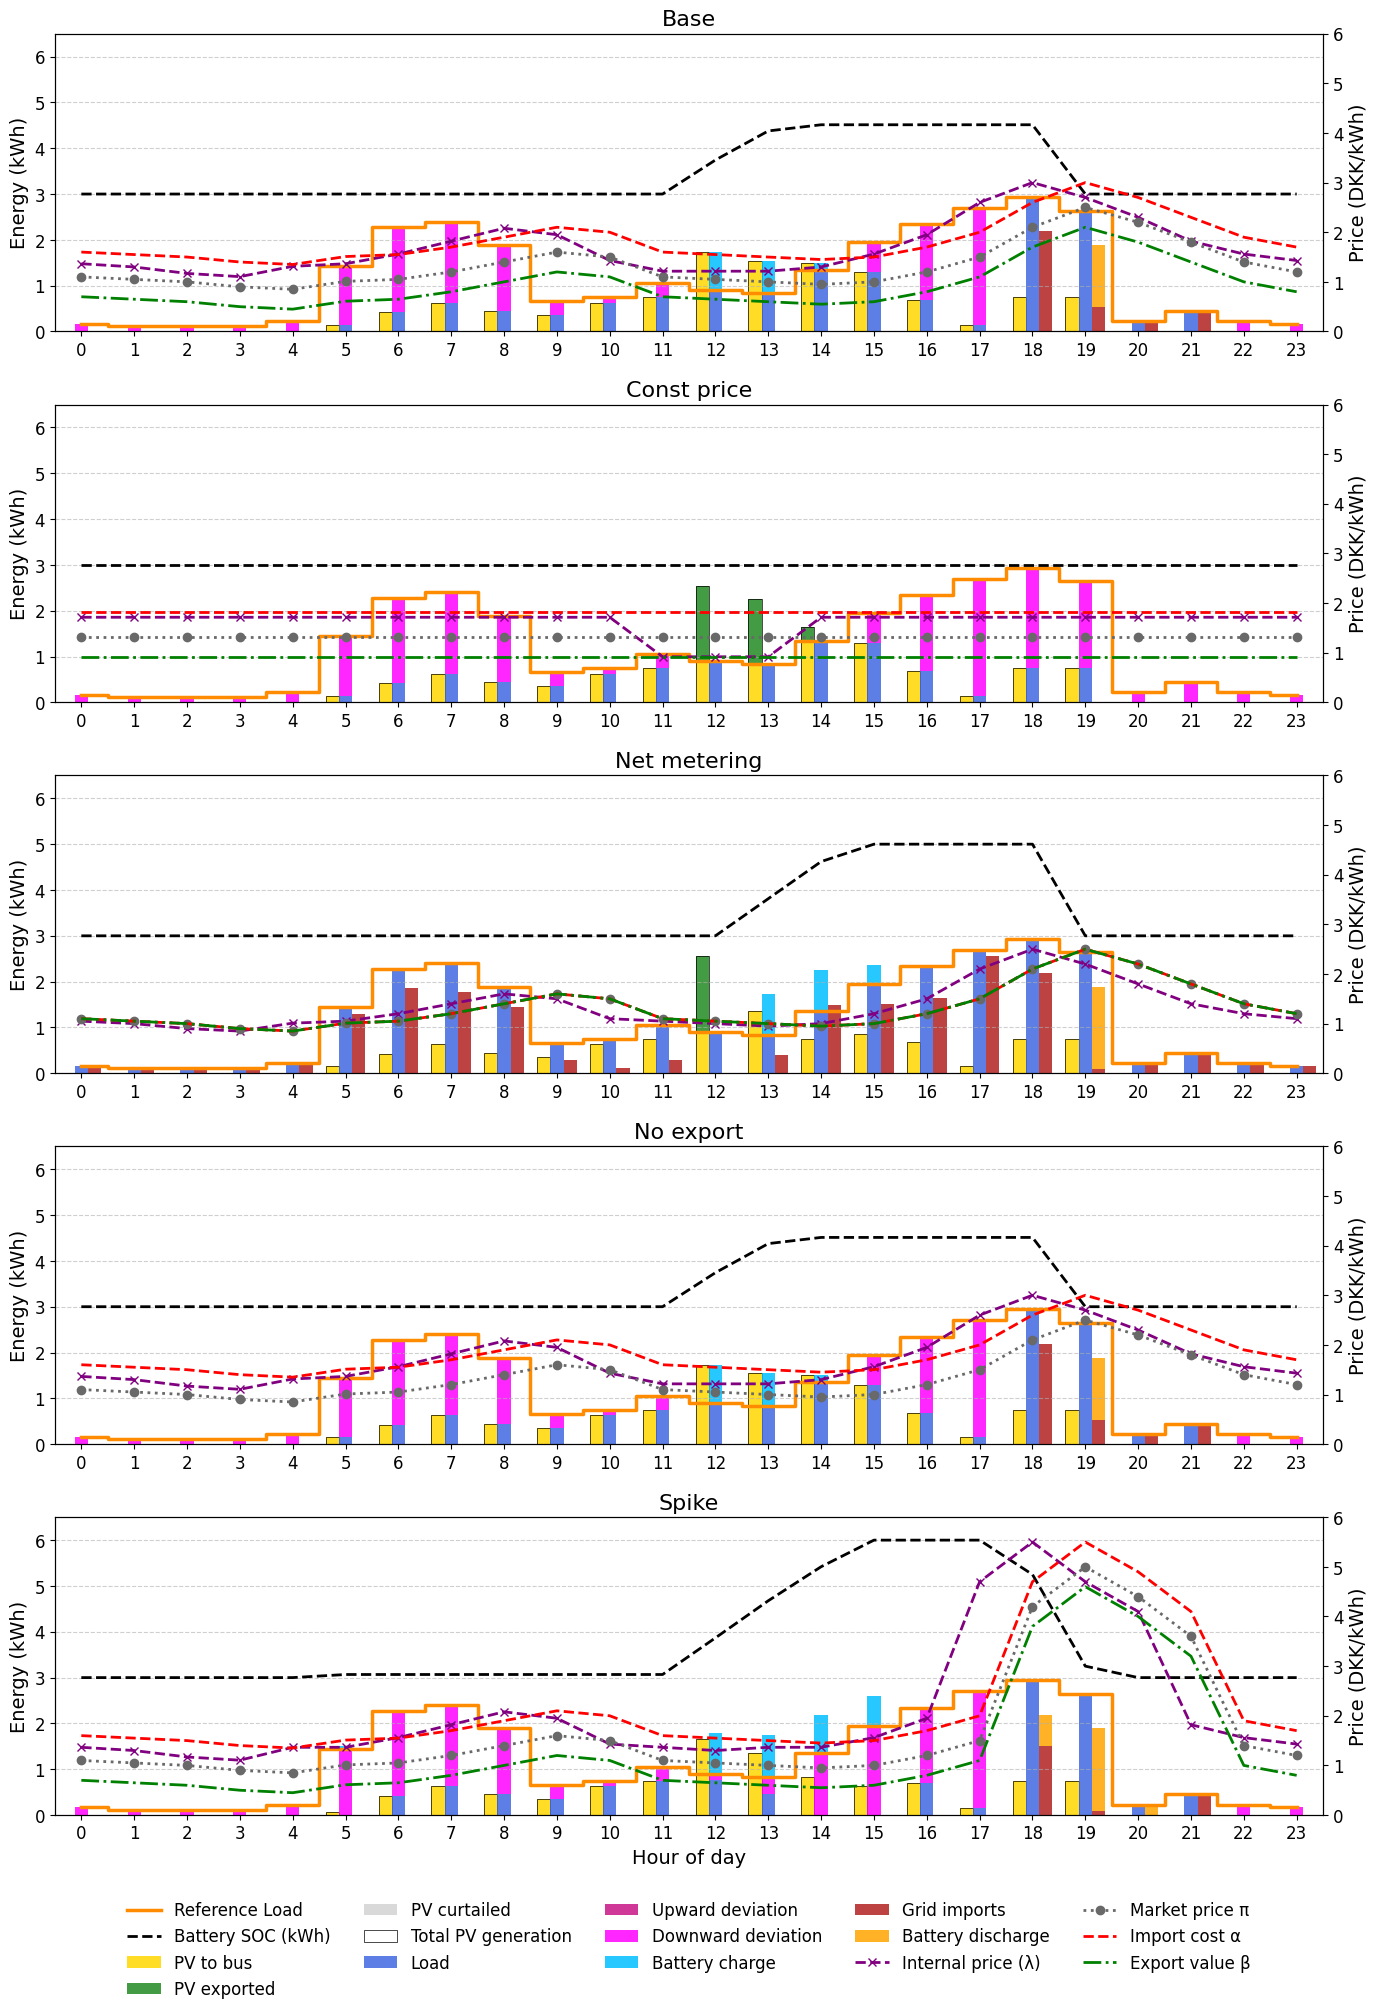

In [28]:
scenario_names = ["Base", "Const price", "Net metering", "No export", "Spike"]

dfs, duals_list, price_list, alpha_list, beta_list, L_refs = [], [], [], [], [], []
results_summary = {}

for scenario_name in scenario_names:
    sc = scenarios[scenario_name]
    input_data = build_input_data_1c(base, sc)  # ⚡ must include battery vars
    problem = LP_OptimizationProblem(input_data)
    problem.run()

    # --- Get results as DataFrame ---
    df = results_to_dataframe(problem.results, base["T"])

    if scenario_name == "Net metering":
        df = clean_net_metering_solution(df)

    dfs.append(df)

    # --- Store duals and prices ---
    duals = [problem.results.duals[f"constr[{i}]"] for i in range(1, base["T"]+1)]
    duals_list.append(duals)
    price_list.append(sc["price"])
    alpha_list.append(sc["price"] + sc["imp"])
    beta_list.append(sc["price"] - sc["exp"])
    L_refs.append(base.get("L_ref", None))  # optional reference load

    # --- Summaries ---
    mu = problem.results.duals.get("constr[0]", np.nan)
    lambdas = duals
    results_summary[scenario_name] = {
        "Objective": problem.results.objective_value,
        "Total import": df.get("e", pd.Series(0)).sum(),
        "Total export": df.get("s", pd.Series(0)).sum(),
        "Total curtailed": df.get("c", pd.Series(0)).sum(),
        "Total load": df.get("l", pd.Series(0)).sum(),
        "mu": mu,
        "lambda_mean": np.mean(lambdas),
        "lambda_min": np.min(lambdas),
        "lambda_max": np.max(lambdas),
    }

# --- Export summary table ---
df_results = pd.DataFrame(results_summary).T
print(df_results.to_latex(float_format="%.2f",
                          caption="Primal and dual results with battery by scenario",
                          label="tab:results_battery"))

# --- Plot all scenarios ---
plot_scenarios_subplots_battery(
    dfs, scenario_names, price_list, alpha_list, beta_list, duals_list,
    L_ref_list=L_refs, ylim=(0,6.5)
)

In [22]:
df_results

,Objective,Total import,Total export,Total curtailed,Total load,mu,lambda_mean,lambda_min,lambda_max
Base,29.841945,3.394200,0.00,0.0,14.865,-1.430000,-1.680125,-3.000000,-1.105000
Const price,27.497139,0.000000,3.36,0.0,10.110,-1.714917,-1.615448,-1.714917,-0.919167
Net metering,23.146594,18.769444,1.65,0.0,27.945,-1.100000,-1.319167,-2.500000,-0.850000
No export,29.841945,3.394200,0.00,0.0,14.865,-1.430000,-1.680125,-3.000000,-1.105000


In [14]:
def check_balances(df, P_pv, eta_ch=0.9, eta_dis=0.9, tol=1e-6, verbose=True):
    """
    Check per-hour physical balances from the results DataFrame.
    Assumes df has columns: l, p, e, s, c, b_ch, b_dis, soc (optional).
    P_pv: array-like of hourly PV availability.
    """
    import numpy as np
    import pandas as pd

    T = len(df)
    P_pv = np.asarray(P_pv)

    # Main bus balance: l + b_ch  ?=  p + e + η_dis * b_dis
    left  = df["l"].values + df.get("b_ch", 0).values
    right = df["p"].values + df["e"].values + eta_dis * df.get("b_dis", 0).values
    res_bus = left - right

    # PV balance: p + s + c  ?=  P_pv
    res_pv = (df["p"].values + df["s"].values + df["c"].values) - P_pv

    # (Optional) SOC dynamics: E_t = E_{t-1} + η_ch b_ch - b_dis
    # If 'soc' exists, we can check the dynamic residuals too
    if "soc" in df.columns:
        soc = df["soc"].values
        res_soc = np.zeros(T)
        for t in range(1, T):
            res_soc[t] = soc[t] - (soc[t-1] + eta_ch * df.get("b_ch",0).values[t] - df.get("b_dis",0).values[t])
    else:
        res_soc = None

    if verbose:
        def _report(name, r):
            print(f"{name}: max|res|={np.max(np.abs(r)):.2e}")
            bad = np.where(np.abs(r) > tol)[0]
            if bad.size:
                print(f"  Failing hours (|res|> {tol}): {bad.tolist()}")
        _report("Main balance (l+b_ch)-(p+e+η_dis*b_dis)", res_bus)
        _report("PV balance (p+s+c)-P_pv", res_pv)
        if res_soc is not None:
            _report("SOC dynamics residual", res_soc)

    return res_bus, res_pv, res_soc

def collect_duals_from_problem(problem, T):
    """
    Collect relevant dual series (λ, ρ, κ, etc.) from the solved LP.
    Works for both battery and non-battery cases.
    """
    duals_raw = problem.results.duals
    out = {}

    # Standard structure: constr[0] = mu, next T = λ_t, next T = ρ_t
    out["mu"] = duals_raw.get("constr[0]", None)

    # λ (hourly load balance)
    lambdas = [duals_raw.get(f"constr[{i}]", np.nan) for i in range(1, T+1)]
    out["lambda"] = np.array(lambdas)

    # ρ (PV balance)
    rhos = [duals_raw.get(f"constr[{i}]", np.nan) for i in range(T+1, 2*T+1)]
    out["rho"] = np.array(rhos)

    # --- Additional named duals if present ---
    def try_series(prefix):
        vals = []
        for t in range(T):
            key = f"{prefix}[{t}]"
            if key in duals_raw:
                vals.append(duals_raw[key])
        return np.array(vals) if len(vals) > 0 else None

    out["kappa"] = try_series("soc_dyn")   # battery dynamic duals
    out["omega"] = try_series("soc_cap")   # capacity constraint duals
    out["alpha"] = try_series("pch")       # charge power duals
    out["beta"]  = try_series("pdis")      # discharge power duals

    return out

def collect_duals_by_index(problem, T):
    """Extract structured duals from problem.results.duals by known index positions."""
    all_duals = [problem.results.duals[f"constr[{i}]"] for i in range(len(problem.results.duals))]

    # Convert slices to numpy arrays to enable elementwise operations
    duals = {
        "lambda": np.array(all_duals[0:T]),                # load balance
        "rho": np.array(all_duals[T:2*T]),                 # PV split
        "nu": np.array(all_duals[2*T:3*T]),                # l_max
        "delta": np.array(all_duals[3*T:4*T]),             # load deviation
        "alpha": np.array(all_duals[4*T:5*T]),             # b_ch ≤ Pch_max
        "beta": np.array(all_duals[5*T:6*T]),              # b_dis ≤ Pdis_max
        "kappa": np.array(all_duals[6*T:7*T]),             # SOC dynamics
        "omega_up": np.array(all_duals[7*T:8*T]),          # SOC ≤ cap
        "omega_low": np.array(all_duals[8*T:9*T]),         # SOC ≥ 0
        "sigma": np.array(all_duals[9*T:])                 # final SOC
    }
    return duals

def plot_duals_quick(duals_dict, title="Dual profiles"):
    """
    Plot key dual variables from the LP with battery.
    Expects keys: lambda, rho, kappa, alpha, beta, omega_up, omega_low.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    h = np.arange(len(duals_dict["lambda"]))  # hours

    plt.figure(figsize=(12, 5))

    # Core duals
    plt.plot(h, duals_dict["lambda"], label="λ (energy balance)", color="purple", lw=2)
    plt.plot(h, duals_dict["rho"], label="ρ (PV split)", color="green", lw=2)
    plt.plot(h, duals_dict["kappa"], label="κ (SoC value)", color="black", lw=2, ls="--")

    # Optional: alpha (charge cap)
    if "alpha" in duals_dict and np.isfinite(duals_dict["alpha"]).any():
        yy = np.array(duals_dict["alpha"])
        m = yy > 1e-8
        plt.plot(h[m], yy[m], "o", label="α>0 (charge cap active)", color="dodgerblue")

    # Optional: beta (discharge cap)
    if "beta" in duals_dict and np.isfinite(duals_dict["beta"]).any():
        yy = np.array(duals_dict["beta"])
        m = yy > 1e-8
        plt.plot(h[m], yy[m], "v", label="β>0 (discharge cap active)", color="tomato")

    # Optional: omega_up and omega_low
    if "omega_up" in duals_dict and np.isfinite(duals_dict["omega_up"]).any():
        yy = np.array(duals_dict["omega_up"])
        m = yy > 1e-8
        plt.plot(h[m], yy[m], "s", label="ω_up>0 (SoC cap active)", color="gray")
    if "omega_low" in duals_dict and np.isfinite(duals_dict["omega_low"]).any():
        yy = np.array(duals_dict["omega_low"])
        m = yy > 1e-8
        plt.plot(h[m], yy[m], "d", label="ω_low>0 (SoC lower bound)", color="lightgray")

    plt.title(title)
    plt.xlabel("Hour of day")
    plt.ylabel("Dual value (DKK/kWh)")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend(loc="upper right", ncol=2)
    plt.tight_layout()
    plt.show()

def duals_to_dataframe(duals_dict):
    """
    Convert structured duals (from collect_duals_by_index) into a readable DataFrame
    with 24 columns (one per hour).
    """
    df = pd.DataFrame({name: np.round(values, 4) for name, values in duals_dict.items()
                       if len(values) == len(duals_dict["lambda"])})
    # Transpose so dual types are rows, hours are columns
    df = df.T
    df.columns = [f"h{t}" for t in range(len(df.columns))]
    return df

In [15]:
sc = scenarios["Base"]
input_data = build_input_data_1c(base, sc)
problem = LP_OptimizationProblem(input_data)
problem.run()

duals = collect_duals_by_index(problem, base["T"])
df_duals = duals_to_dataframe(duals)
df_duals.T

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 217 rows, 240 columns and 504 nonzeros
Model fingerprint: 0x545a2413
Coefficient statistics:
  Matrix range     [9e-01, 1e+00]
  Objective range  [4e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 6e+00]
Presolve removed 144 rows and 73 columns
Presolve time: 0.00s
Presolved: 73 rows, 167 columns, 269 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1224500e+01   3.078667e+01   0.000000e+00      0s
      73    2.9841945e+01   0.000000e+00   0.000000e+00      0s

Solved in 73 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.984194500e+01


,lambda,rho,nu,delta,alpha,beta,kappa,omega_up,omega_low
h0,-1.430,-1.430,0.0,1.430,0.0,0.0,-2.7,0.0,0.0
h1,-1.365,-1.365,0.0,1.365,0.0,0.0,-2.7,0.0,0.0
h2,-1.300,-1.300,0.0,1.300,0.0,0.0,-2.7,0.0,0.0
h3,-1.170,-1.260,0.0,1.170,0.0,0.0,-2.7,0.0,0.0
h4,-1.105,-1.325,0.0,1.105,0.0,0.0,-2.7,0.0,0.0
h5,-1.313,-1.313,0.0,1.313,0.0,0.0,-2.7,0.0,0.0
h6,-1.365,-1.365,0.0,1.365,0.0,0.0,-2.7,0.0,0.0
h7,-1.560,-1.560,0.0,1.560,0.0,0.0,-2.7,0.0,0.0
h8,-1.820,-1.820,0.0,1.820,0.0,0.0,-2.7,0.0,0.0
h9,-2.080,-2.080,0.0,2.080,0.0,0.0,-2.7,0.0,0.0


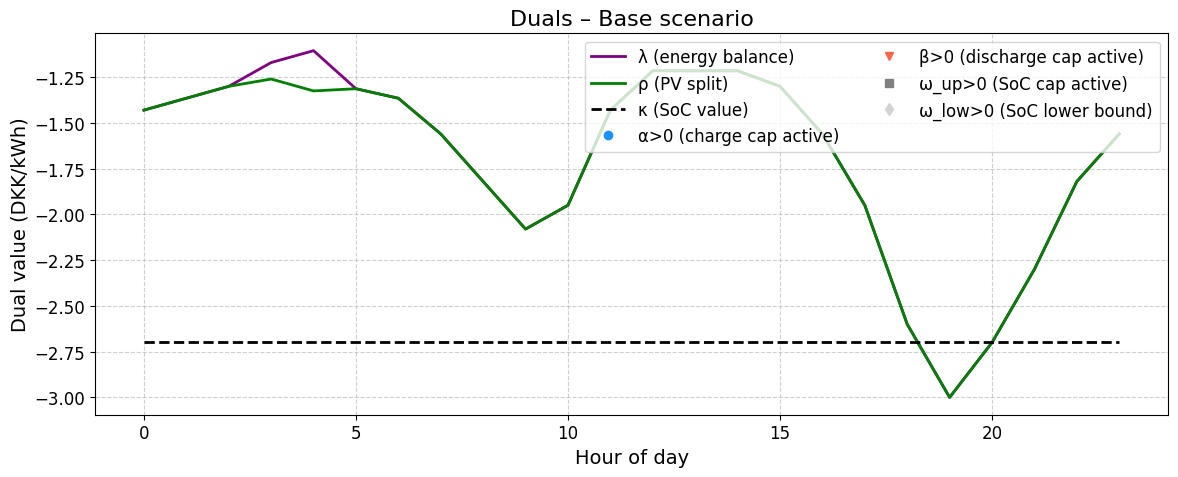

In [16]:
plot_duals_quick(duals, title="Duals – Base scenario")

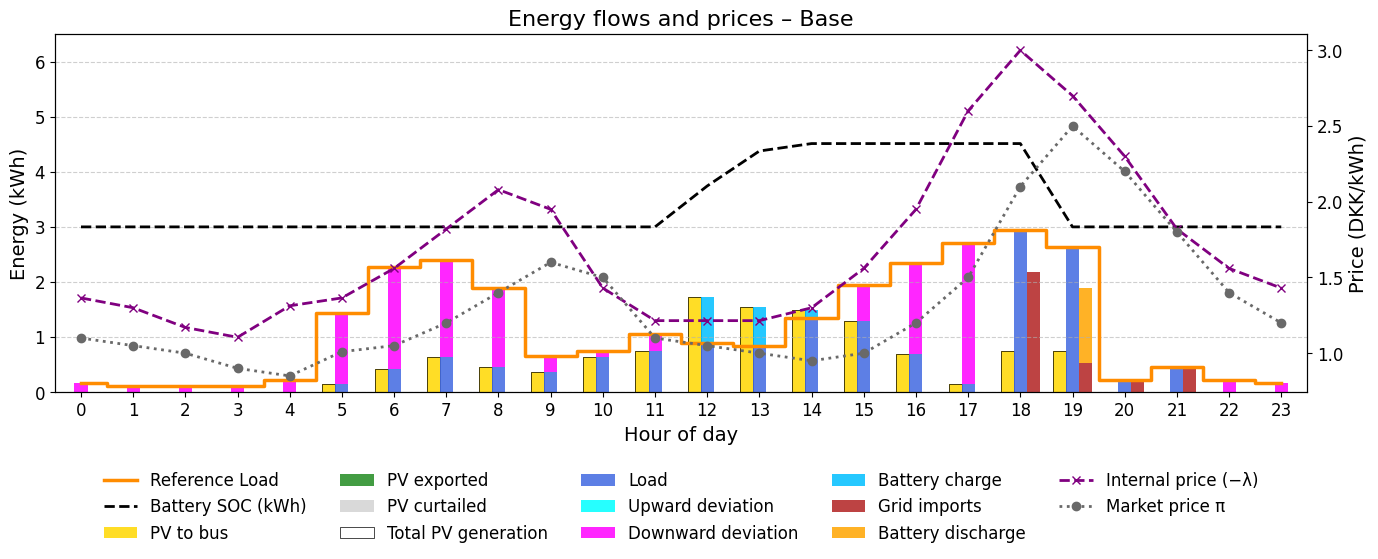

In [17]:
plot_hourly_flows_with_prices(dfs[0], scenario_names[0],
                             duals=duals_list[0],
                             price=price_list[0],
                             alpha=alpha_list[0],
                             beta=beta_list[0],
                             L_ref=L_refs[0],
                             show_battery=True)